In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from cycler import cycler
import os

def configure_scientific_style():
    """Configure matplotlib for scientific publication quality plots."""
    # Create output directory if it doesn't exist
    os.makedirs("figures", exist_ok=True)
    
    # Set up a scientific style with smoke gray background
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Define a color-blind friendly scientific color palette
    # Based on ColorBrewer and scientific publication standards
    scientific_colors = ['#0173B2', '#DE8F05', '#029E73', '#D55E00', 
                        '#CC78BC', '#CA9161', '#FBAFE4', '#949494', 
                        '#ECE133', '#56B4E9']
    
    plt.rcParams['axes.prop_cycle'] = cycler(color=scientific_colors)
    plt.rcParams['figure.facecolor'] = "#FFFFFF"  # Smoke gray background
    plt.rcParams['axes.facecolor'] = '#F5F5F5'    # Smoke gray background
    plt.rcParams['savefig.facecolor'] = '#F5F5F5' # Smoke gray background
    plt.rcParams['grid.color'] = '#CCCCCC'        # Light gray grid
    plt.rcParams['font.family'] = 'serif'         # Standard serif font for academic publishing
    plt.rcParams['font.size'] = 14                # Professional font size
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['legend.fontsize'] = 14
    plt.rcParams['figure.titlesize'] = 18

def exponential_decay(x, a, b, c):
    """Exponential decay function: y = a * exp(-b * x) + c"""
    return a * np.exp(-b * x) + c

def analyze_exponential_decay(filename):
    
    # Load data
    with open(filename, 'r') as f:
        data = json.load(f)
    
    configure_scientific_style()
    
    # Store results
    r_squared_values = {}
    decay_rates = {}
    
    # Analyze each ansatz
    for ansatz_id, variances in data.items():
        cycles = np.array([int(k) for k in variances.keys()])
        variance_values = np.array(list(variances.values()))
        
        # Remove any zero or negative values for fitting
        positive_mask = variance_values > 0
        cycles_pos = cycles[positive_mask]
        variance_pos = variance_values[positive_mask]
        
        if len(variance_pos) > 3:  # Need enough points for fitting
            try:
                # Fit exponential decay: variance = a * exp(-b * cycles) + c
                initial_guess = [max(variance_pos), 0.5, min(variance_pos)/10]
                popt, _ = curve_fit(exponential_decay, cycles_pos, variance_pos, 
                                 p0=initial_guess, maxfev=5000)
                
                # Calculate R-squared
                y_pred = exponential_decay(cycles_pos, *popt)
                ss_res = np.sum((variance_pos - y_pred) ** 2)
                ss_tot = np.sum((variance_pos - np.mean(variance_pos)) ** 2)
                r_squared = 1 - (ss_res / ss_tot)
                
                r_squared_values[int(ansatz_id)] = r_squared
                decay_rates[int(ansatz_id)] = popt[1]  # decay rate parameter
                
            except Exception as e:
                print(f"Failed to fit ansatz {ansatz_id}: {e}")
    
    return r_squared_values, decay_rates

def create_analysis_plot(r_squared_values, depth):
    """Create visualization of exponential decay analysis - R² values only."""
    
    # Sort by ansatz ID for consistent plotting
    ansatz_ids = sorted(r_squared_values.keys())
    r_squared_vals = [r_squared_values[aid] for aid in ansatz_ids]
    
    # Create single figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    #fig.suptitle(f'Exponential Decay Analysis: Quantum Circuit Ansätze (Depth {depth})', 
    #             fontsize=18, fontweight='bold', y=0.95)
    
    # Color coding based on R² quality
    colors = []
    for r2 in r_squared_vals:
        if r2 > 0.9:
            colors.append('#029E73')  # Green - Excellent
        elif r2 > 0.8:
            colors.append('#0173B2')  # Blue - Good
        elif r2 > 0.6:
            colors.append('#DE8F05')  # Orange - Moderate
        else:
            colors.append('#D55E00')  # Red - Poor
    
    # Plot R² values with quality thresholds
    bars = ax.bar(ansatz_ids, r_squared_vals, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add quality threshold lines
    ax.axhline(y=0.9, color='#029E73', linestyle='--', alpha=0.7, label='Excellent (R² > 0.9)')
    ax.axhline(y=0.8, color='#0173B2', linestyle='--', alpha=0.7, label='Good (R² > 0.8)')
    ax.axhline(y=0.6, color='#DE8F05', linestyle='--', alpha=0.7, label='Moderate (R² > 0.6)')
    
    ax.set_xlabel('Ansatz identifier', fontweight='bold')
    ax.set_ylabel('Coefficient of Determination (R²)', fontweight='bold')
    #ax.set_title('Exponential Fit Quality Assessment', fontweight='bold')
    ax.set_ylim(0, 1.05)
    #ax.legend(loc='lower right', framealpha=0.9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticks(ansatz_ids)
    
    # Add R² values on bars
    for bar, r2 in zip(bars, r_squared_vals):
        height = bar.get_height()
        if height > 0.05:
            ax.text(bar.get_x() + bar.get_width()/2, height - 0.1,
                f'{r2:.3f}', ha='center', va='bottom', fontsize=16, rotation=90)
        else:
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                f'{r2:.3f}', ha='center', va='bottom', fontsize=16, rotation=90)
    
    plt.tight_layout()
    plt.savefig(f'figures/exponential_decay_analysis_depth_{depth}.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    """Main analysis function."""
    embeddings = ["angle_embedding", "amplitude_embedding"]
    depth = 2
    embedding = embeddings[1]
    filename = f'..//{embedding}_depth_{depth}.json'
    
    # Perform exponential decay analysis
    r_squared_values, decay_rates = analyze_exponential_decay(filename)
    
    # Create visualization (single plot only)
    create_analysis_plot(r_squared_values, depth)

C:\Users\valte\AppData\Local\Temp\ipykernel_32480\2173477021.py:38: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
C:\Users\valte\AppData\Local\Temp\ipykernel_32480\2173477021.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exponential_decay, cycles_pos, variance_pos,


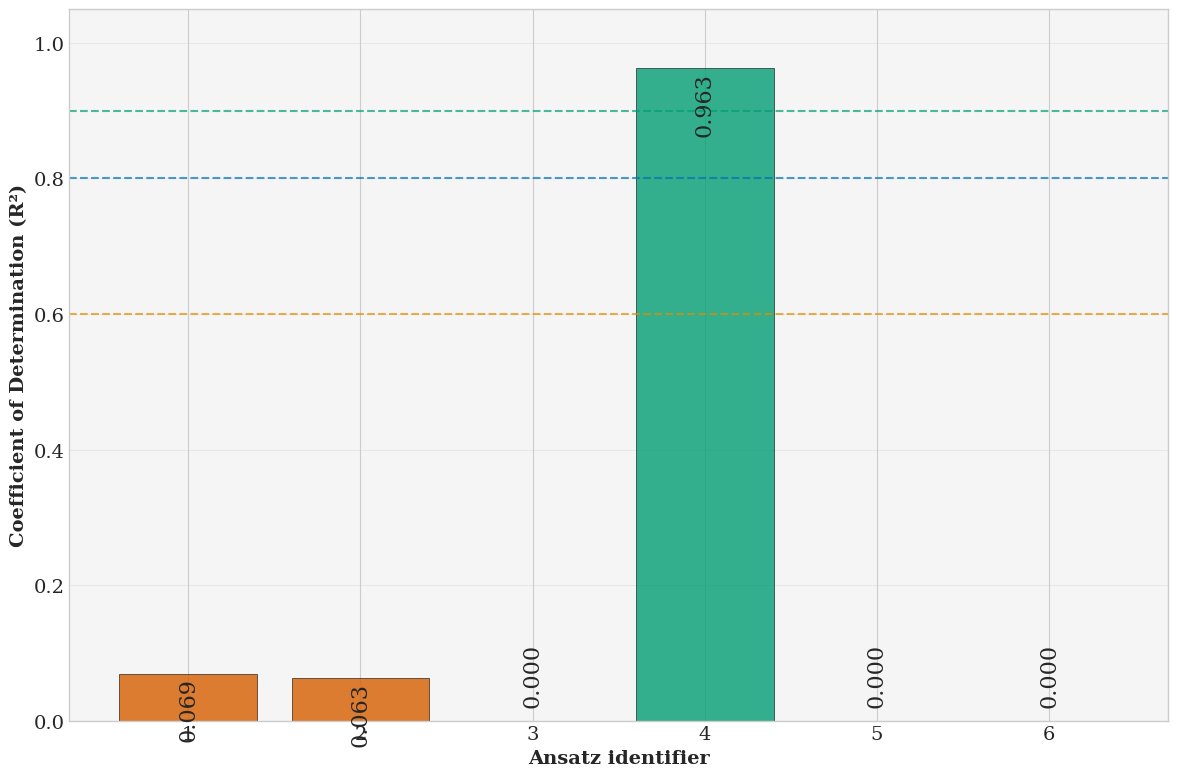

In [2]:
main()